### Introduction

This notebook creates a Sionna Scene (https://nvlabs.github.io/sionna/api/rt.html#scene) using openstreetmap. This can be used as an alternative to exporting scene from Blender (https://www.youtube.com/watch?v=7xHLDxUaQ7c).

In [97]:
import ipyleaflet
import IPython.display
import ipyvolume.pylab as p3
import pyproj
import shapely
from shapely.geometry import shape
from shapely.ops import transform
import math
import pyvista as pv
import numpy as np
import osmnx as ox
from shapely.geometry import Polygon, Point, LineString
import os
from pyproj import Transformer
import open3d as o3d
import xml.etree.ElementTree as ET
import xml.dom.minidom as minidom

In [117]:
# Set the center position lat and lon as a starting point. Use any string of your choice for LOCATION_STR
center_lat = 14.557097311312177
center_lon = 121.02000072883868
LOCATION_STR = "PHILLIPINES"

#### Initialize Sionna Scene XML object and add defaults

In [143]:
# Set up default values for resolution
spp_default = 4096
resx_default = 1024
resy_default = 768

# Define camera settings
camera_settings = {
    "rotation": (0, 0, -90),  # Assuming Z-up orientation
    "fov": 42.854885
}

# Define material colors. This is RGB 0-1 formar https://rgbcolorpicker.com/0-1
material_colors = {
    "mat-itu_concrete": (0.539479, 0.539479, 0.539480),
    "mat-itu_marble": (0.701101, 0.644479, 0.485150),
    "mat-itu_metal": (0.219526, 0.219526, 0.254152),
    "mat-itu_wood": (0.043, 0.58, 0.184),
    "mat-itu_wet_ground": (0.91,0.569,0.055),
}
transformer = Transformer.from_crs("EPSG:4326", "EPSG:26915")
center_26915 = transformer.transform(center_lat,center_lon)
sionna_center_x = center_26915[0]
sionna_center_y = center_26915[1]
sionna_center_z = 0

scene = ET.Element("scene", version="2.1.0")
# Add defaults
ET.SubElement(scene, "default", name="spp", value=str(spp_default))
ET.SubElement(scene, "default", name="resx", value=str(resx_default))
ET.SubElement(scene, "default", name="resy", value=str(resy_default))
# Add integrator
integrator = ET.SubElement(scene, "integrator", type="path")
ET.SubElement(integrator, "integer", name="max_depth", value="12")

# Define materials
for material_id, rgb in material_colors.items():
    bsdf_twosided = ET.SubElement(scene, "bsdf", type="twosided", id=material_id)
    bsdf_diffuse = ET.SubElement(bsdf_twosided, "bsdf", type="diffuse")
    ET.SubElement(bsdf_diffuse, "rgb", value=f"{rgb[0]} {rgb[1]} {rgb[2]}", name="reflectance")

# Add emitter
emitter = ET.SubElement(scene, "emitter", type="constant", id="World")
ET.SubElement(emitter, "rgb", value="1.000000 1.000000 1.000000", name="radiance")

# Add camera (sensor)
sensor = ET.SubElement(scene, "sensor", type="perspective", id="Camera")
ET.SubElement(sensor, "string", name="fov_axis", value="x")
ET.SubElement(sensor, "float", name="fov", value=str(camera_settings["fov"]))
ET.SubElement(sensor, "float", name="principal_point_offset_x", value="0.000000")
ET.SubElement(sensor, "float", name="principal_point_offset_y", value="-0.000000")
ET.SubElement(sensor, "float", name="near_clip", value="0.100000")
ET.SubElement(sensor, "float", name="far_clip", value="10000.000000")
sionna_transform = ET.SubElement(sensor, "transform", name="to_world")
ET.SubElement(sionna_transform, "rotate", x="1", angle=str(camera_settings["rotation"][0]))
ET.SubElement(sionna_transform, "rotate", y="1", angle=str(camera_settings["rotation"][1]))
ET.SubElement(sionna_transform, "rotate", z="1", angle=str(camera_settings["rotation"][2]))
camera_position = np.array([0, 0, 100])  # Adjust camera height
ET.SubElement(sionna_transform, "translate", value=" ".join(map(str, camera_position)))
sampler = ET.SubElement(sensor, "sampler", type="independent")
ET.SubElement(sampler, "integer", name="sample_count", value="$spp")
film = ET.SubElement(sensor, "film", type="hdrfilm")
ET.SubElement(film, "integer", name="width", value="$resx")
ET.SubElement(film, "integer", name="height", value="$resy")

<Element 'integer' at 0x7f3ef7bfbb00>

### Open Interactive map to select Region to be used

Use controls on the map to draw a region of any shape.

In [102]:
m = ipyleaflet.Map(center=(center_lat, center_lon), zoom=16)
dc = ipyleaflet.DrawControl()
m.add(dc)
m

Map(center=[14.557097311312177, 121.02000072883868], controls=(ZoomControl(options=['position', 'zoom_in_text'…

In [103]:
# Get coordinates in meter for the area of interst polygon (This will be used in next steps)
wsg84 = pyproj.CRS("epsg:4326")
lambert = pyproj.CRS("epsg:26915")
transformer = pyproj.Transformer.from_crs(wsg84, lambert, always_xy=True)
coords = [transformer.transform(x, y) for x, y in dc.last_draw['geometry']['coordinates'][0]]

aoi_polygon = shapely.geometry.Polygon(coords)

In [144]:
# Store center of the selected area to be used in calculations later on
center_x = aoi_polygon.centroid.x
center_y = aoi_polygon.centroid.y

In [145]:
# Set Location of the directory where scene and objects will be stored
LOCATION_DIR = f"{LOCATION_STR}_{center_x}_{center_y}"

In [ ]:
# Create Directories
os.mkdir(f"simple_scene/{LOCATION_DIR}")
os.mkdir(f"simple_scene/{LOCATION_DIR}/mesh")  

FileExistsError: [Errno 17] File exists: 'simple_scene/PHILLIPINES_-3366469.1469016294_18070465.15989536'

In [147]:
# Utility Function
def points_2d_to_poly(points, z):
    """Convert a sequence of 2d coordinates to a polydata with a polygon."""
    faces = [len(points), *range(len(points))]
    poly = pv.PolyData([p + (z,) for p in points], faces=faces)
    return poly

### Create Ground mesh and add to the scene

In [148]:
wsg84 = pyproj.CRS("epsg:4326")
lambert = pyproj.CRS("epsg:26915")
transformer = pyproj.Transformer.from_crs(wsg84, lambert, always_xy=True)
coords = [transformer.transform(x, y) for x, y in dc.last_draw['geometry']['coordinates'][0]]

ground_polygon = shapely.geometry.Polygon(coords)
z_coordinates = np.full(len(ground_polygon.exterior.coords), 0)  # Assuming the initial Z coordinate is zmin
exterior_coords = ground_polygon.exterior.coords
oriented_coords = list(exterior_coords)
# Ensure counterclockwise orientation
if ground_polygon.exterior.is_ccw:
    oriented_coords.reverse()
points = [(coord[0]-center_x, coord[1]-center_y) for coord in oriented_coords]
# bounding polygon
boundary_points_polydata = points_2d_to_poly(points, z_coordinates[0])
edge_polygon = boundary_points_polydata
footprint_plane = edge_polygon.delaunay_2d()
footprint_plane.points[:] = (footprint_plane.points - footprint_plane.center)*1.5 + footprint_plane.center
pv.save_meshio(f"simple_scene/{LOCATION_DIR}/mesh/ground.ply",footprint_plane)

material_type = "mat-itu_wet_ground"
sionna_shape = ET.SubElement(scene, "shape", type="ply", id=f"mesh-ground")
ET.SubElement(sionna_shape, "string", name="filename", value=f"simple_scene/{LOCATION_DIR}/mesh/ground.ply")
bsdf_ref = ET.SubElement(sionna_shape, "ref", id=material_type, name="bsdf")
ET.SubElement(sionna_shape, "boolean", name="face_normals",value="true")

Warning: PLY doesn't support 64-bit integers. Casting down to 32-bit.

<Element 'boolean' at 0x7f3ef759dc10>

#### Create Buildings mesh and add to the scene

First download 2D buildings from openstreetmap using OSMNX (https://osmnx.readthedocs.io/en/stable/)

In [149]:
import osmnx as ox
wsg84 = pyproj.CRS("epsg:4326")
lambert = pyproj.CRS("epsg:4326")
transformer = pyproj.Transformer.from_crs(wsg84, lambert, always_xy=True)
coords = [transformer.transform(x, y) for x, y in dc.last_draw['geometry']['coordinates'][0]]

osm_polygon = shapely.geometry.Polygon(coords)
# Query the OpenStreetMap data
buildings = ox.geometries.geometries_from_polygon(osm_polygon, tags={'building': True})

# Filter buildings that intersect with the polygon
filtered_buildings = buildings[buildings.intersects(osm_polygon)]

In [150]:
filtered_buildings.head(5)

geometry  \
element_type osmid                                                         
way          28394355  POLYGON ((121.00592 14.55796, 121.00575 14.557...   
             33318678  POLYGON ((121.01124 14.55459, 121.01128 14.554...   
             35798959  POLYGON ((121.01167 14.55253, 121.01166 14.552...   
             36786781  POLYGON ((121.01147 14.55594, 121.01182 14.555...   
             36980368  POLYGON ((121.01238 14.55856, 121.01241 14.558...   

                      addr:city addr:postcode  \
element_type osmid                              
way          28394355    Makati          1235   
             33318678       NaN           NaN   
             35798959    Makati          1230   
             36786781    Makati           NaN   
             36980368       NaN           NaN   

                                           addr:street           alt_name  \
element_type osmid                                                          
way          28394355  President Sergio Osmeña Highway  Cash & Carry Mall   
             33318678                       Washington                NaN   
             35798959                Washington Street                NaN   
             36786781                   Facundo Street                NaN   
             36980368                              NaN                NaN   

                                                            name  \
element_type osmid                                                 
way          28394355                   Cash & Carry Supermarket   
             33318678                         Kolesiyum ng Bayan   
             35798959                Pio del Pilar Barangay Hall   
             36786781  Heneral Pio del Pilar Elementary School I   
             36980368                                        NaN   

                                                               operator  \
element_type osmid                                                        
way          28394355                                               NaN   
             33318678                                               NaN   
             35798959                                               NaN   
             36786781  District III Makati City Schools Division, DepEd   
             36980368                                               NaN   

                      wheelchair   amenity  \
element_type osmid                           
way          28394355        NaN       NaN   
             33318678        NaN       NaN   
             35798959        NaN  townhall   
             36786781        NaN    school   
             36980368        NaN       NaN   

                                                                   nodes  ...  \
element_type osmid                                                        ...   
way          28394355  [311891172, 2949599042, 311891173, 2949599044,...  ...   
             33318678  [378942550, 734954037, 378978883, 378978884, 7...  ...   
             35798959  [10236676812, 418527445, 2684764277, 418527452...  ...   
             36786781  [427681096, 427681097, 427681098, 427681099, 4...  ...   
             36980368  [6574397792, 3909460102, 3909460096, 390946009...  ...   

                      bench addr:barangay admin_level emergency:amenity  \
element_type osmid                                                        
way          28394355   NaN           NaN         NaN               NaN   
             33318678   NaN           NaN         NaN               NaN   
             35798959   NaN           NaN         NaN               NaN   
             36786781   NaN           NaN         NaN               NaN   
             36980368   NaN           NaN         NaN               NaN   

                      emergency:social_facility emergency:social_facility:for  \
element_type osmid                                                              
way          28394355                       NaN                  

Following code uses building footprints and extrude them to create a triangular mesh and add in Sionna scene one by one.

In [151]:
buildings_list = filtered_buildings.to_dict('records')
source_crs = pyproj.CRS(filtered_buildings.crs)
target_crs = pyproj.CRS('EPSG:26915')
transformer = pyproj.Transformer.from_crs(source_crs, target_crs, always_xy=True).transform
for idx, building in enumerate(buildings_list):
    # Convert building geometry to a shapely polygon
    building_polygon = shape(building['geometry'])
    if building_polygon.geom_type != 'Polygon':
        continue
    building_polygon = transform(transformer, building_polygon)
    if math.isnan(float(building['building:levels'])):
        building_height = 3.5
    else:
        building_height = int(building['building:levels']) * 3.5
    z_coordinates = np.full(len(building_polygon.exterior.coords), 0)  # Assuming the initial Z coordinate is zmin
    exterior_coords = building_polygon.exterior.coords
    oriented_coords = list(exterior_coords)
    # Ensure counterclockwise orientation
    if building_polygon.exterior.is_ccw:
        oriented_coords.reverse()
    points = [(coord[0]-center_x, coord[1]-center_y) for coord in oriented_coords]
    # bounding polygon
    boundary_points_polydata = points_2d_to_poly(points, z_coordinates[0])
    edge_polygon = boundary_points_polydata
    footprint_plane = edge_polygon.delaunay_2d()
    footprint_plane = footprint_plane.triangulate()
    footprint_3D = footprint_plane.extrude((0, 0, building_height), capping=True)
    footprint_3D.save(f"simple_scene/{LOCATION_DIR}/mesh/building_{idx}.ply")
    local_mesh = o3d.io.read_triangle_mesh(f"simple_scene/{LOCATION_DIR}/mesh/building_{idx}.ply")
    o3d.io.write_triangle_mesh(f"simple_scene/{LOCATION_DIR}/mesh/building_{idx}.ply", local_mesh)
    material_type = "mat-itu_marble"
    # Add shape elements for PLY files in the folder
    sionna_shape = ET.SubElement(scene, "shape", type="ply", id=f"mesh-building_{idx}")
    ET.SubElement(sionna_shape, "string", name="filename", value=f"simple_scene/{LOCATION_DIR}/mesh/building_{idx}.ply")
    bsdf_ref = ET.SubElement(sionna_shape, "ref", id= material_type, name="bsdf")
    ET.SubElement(sionna_shape, "boolean", name="face_normals",value="true")

#### Create Roads mesh and add to the scene

In [152]:
def convert_lane_to_numeric(lane):
    try:
        return int(lane)
    except ValueError:
        try:
            return float(lane)
        except ValueError:
            return None

        # Helper function to calculate edge geometry if missing
def calculate_edge_geometry(u, v, data):
    u_data = graph.nodes[u]
    v_data = graph.nodes[v]
    return LineString([(u_data['x'], u_data['y']), (v_data['x'], v_data['y'])])

Get the road network linestring and plot

/root/anaconda3/envs/CondaEnv/lib/python3.10/site-packages/osmnx/utils_graph.py:88: FutureWarning: You are adding a column named 'geometry' to a GeoDataFrame constructed without an active geometry column. Currently, this automatically sets the active geometry column to 'geometry' but in the future that will no longer happen. Instead, either provide geometry to the GeoDataFrame constructor (GeoDataFrame(... geometry=GeoSeries()) or use `set_geometry('geometry')` to explicitly set the active geometry column.
  gdf_edges["geometry"] = np.nan


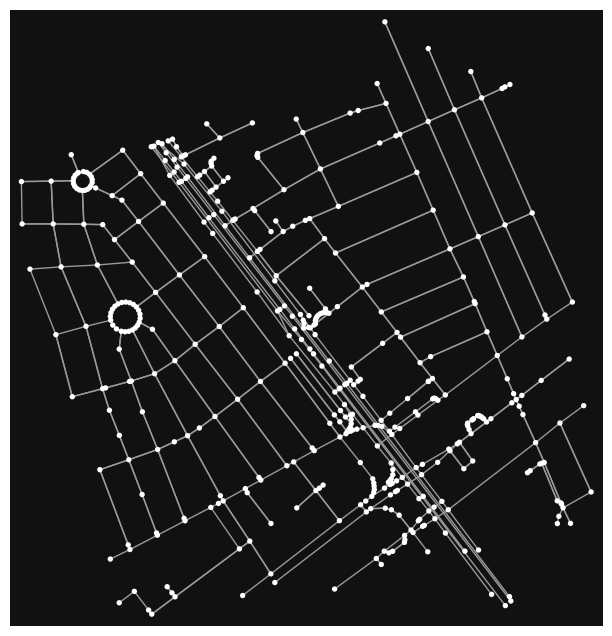

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [156]:
G = ox.graph_from_polygon(polygon = osm_polygon, simplify= False, retain_all=True,truncate_by_edge=True,network_type = 'all_private')
graph = ox.project_graph(G, to_crs='epsg:26915')
ox.plot_graph(graph)

Now convert each line segment into road mesh using lanes as parameter to set road width

In [154]:
# Create a list to store GeoDataFrames for each road segment
gdf_roads_list = []
# Set the fixed Z coordinate for the buffer polygons
Z0 = .25  # You can adjust this value based on the desired elevation of the roads
# Create a list to store the meshes
mesh_list = []
mesh_collection = pv.PolyData()
# Iterate over each edge in the graph
for u, v, key, data in graph.edges(keys=True, data=True):
    # Check if the edge has geometry, otherwise create geometries from the nodes
    if 'geometry' not in data:
        data['geometry'] = calculate_edge_geometry(u, v, data)

    # Get the lanes attribute for the edge
    lanes = data.get('lanes', 1)  # Default to 1 lane if lanes attribute is not available

    if not isinstance(lanes, list):
        lanes = [lanes]
        
    # Convert lane values to numeric (integers or floats) using the helper function
    num_lanes = [convert_lane_to_numeric(lane) for lane in lanes]

    # Filter out None values (representing non-numeric lanes) and calculate the road width
    num_lanes = [lane for lane in num_lanes if lane is not None]
    road_width = num_lanes[0] * 3.5
    # Buffer the LineString with the road width and add Z coordinate
    line_buffer = data['geometry'].buffer(road_width)
    # Convert the buffer polygon to a PyVista mesh
    exterior_coords = line_buffer.exterior.coords
    z_coordinates = np.full(len(line_buffer.exterior.coords), Z0)
    oriented_coords = list(exterior_coords)
    # Ensure counterclockwise orientation
    if line_buffer.exterior.is_ccw:
        oriented_coords.reverse()
    points = [(coord[0]-center_x, coord[1]-center_y) for coord in oriented_coords]
    # bounding polygon
    boundary_points_polydata = points_2d_to_poly(points, z_coordinates[0])
    mesh = boundary_points_polydata.delaunay_2d()
    # Add the mesh to the list
    mesh_collection = mesh_collection + mesh
    mesh_list.append(mesh)
output_file = f"simple_scene/{LOCATION_DIR}/mesh/road_mesh_combined.ply"
pv.save_meshio(output_file,mesh_collection)
material_type = "mat-itu_concrete"
# Add shape elements for PLY files in the folder
sionna_shape = ET.SubElement(scene, "shape", type="ply", id=f"mesh-roads_{idx}")
ET.SubElement(sionna_shape, "string", name="filename", value=f"simple_scene/{LOCATION_DIR}/mesh/road_mesh_combined.ply")
bsdf_ref = ET.SubElement(sionna_shape, "ref", id= material_type, name="bsdf")
ET.SubElement(sionna_shape, "boolean", name="face_normals",value="true")

Warning: PLY doesn't support 64-bit integers. Casting down to 32-bit.

<Element 'boolean' at 0x7f3f4839b6a0>

##### Finally Save the scene file

In [155]:
# Create and write the XML file
tree = ET.ElementTree(scene)
xml_string = ET.tostring(scene, encoding="utf-8")
xml_pretty = minidom.parseString(xml_string).toprettyxml(indent="    ")  # Adjust the indent as needed

with open(f"simple_scene/{LOCATION_DIR}/simple_OSM_scene.xml", "w", encoding="utf-8") as xml_file:
    xml_file.write(xml_pretty)